In [1]:
from Functions_For_LIF_analysis import import_lif_file, quick_view_3d_images, cell_counter_3D, display_all_3Dlayers_from_list
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import copy

In [2]:
#The data used for this 3D image analysis is flawed because of an incorrect experiment design(the additional dye channel pkh26
#made the cell membranes permeable and this made the live/dead cell dyes work incorrectly), therefore the ratios of the cells
#are not correct and the experiments will have to be redone, but this code should be applicable in the same way then too
day5_data = import_lif_file(r"data\RASC025 5 day livedeadpkh26 3D.lif")
day10_data = import_lif_file(r"data\RASC025 live-dead-pkh26 10 day 3D.lif")

List named all_images_3_images was created for 3D images
List named all_images_6_images was created for 3D images


In [ ]:
quick_view_3d_images(day5_data)
quick_view_3d_images(day10_data)

In [ ]:
display_all_3Dlayers_from_list(day5_data)
display_all_3Dlayers_from_list(day10_data)

In [3]:
#The third channel has a seperate dye, that is not necessary for the live/dead ratio count
def remove_channel_data(data):
    data_noCh3 = copy.deepcopy(data)
    for image in data_noCh3:
        if len(image['channel_images']) >= 3:
            del image['channel_images'][2]
            if len(image['variable_names']) >= 3:
                del image['variable_names'][2]
    return data_noCh3

day5_data_noCh3 = remove_channel_data(day5_data)
day10_data_noCh3 = remove_channel_data(day10_data)

In [4]:
def remove_images_of_poor_quality(photo_list, *indices_to_remove):
    cleaned_list = copy.deepcopy(photo_list)
    for index in sorted(indices_to_remove, reverse=True):
        if 0 <= index < len(cleaned_list):
            del cleaned_list[index]
    return cleaned_list

day5_clean = remove_images_of_poor_quality(day5_data_noCh3, 2)
day10_clean = remove_images_of_poor_quality(day10_data_noCh3, 2, 3)

In [ ]:
display_all_3Dlayers_from_list(day5_clean)
display_all_3Dlayers_from_list(day10_clean)

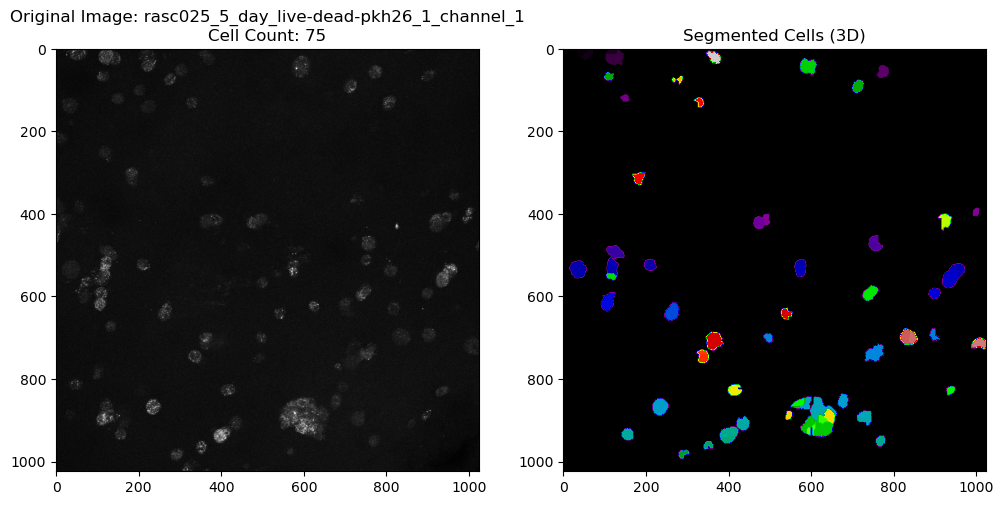

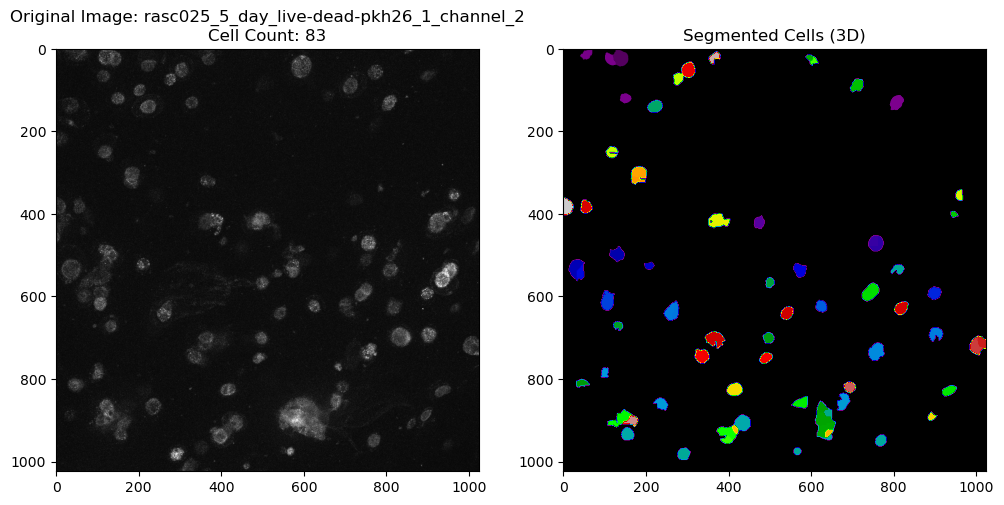

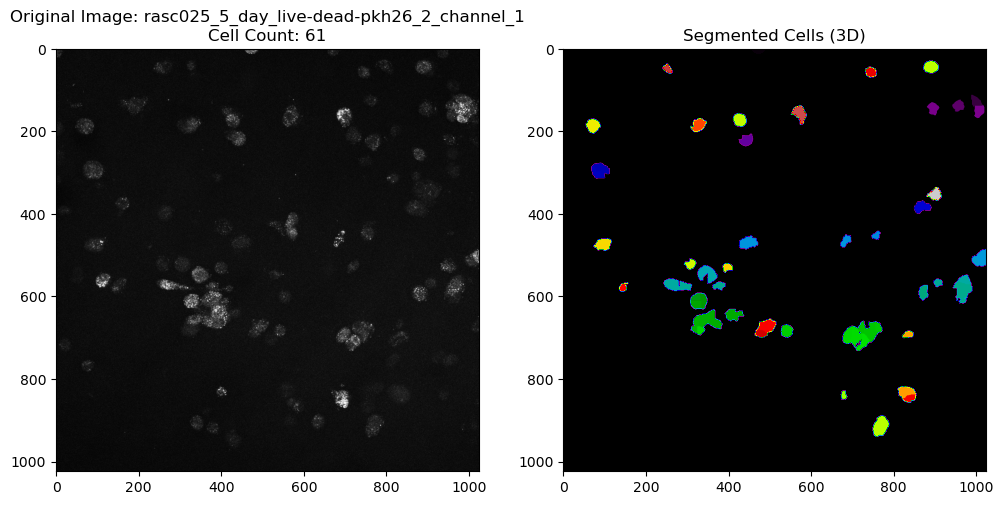

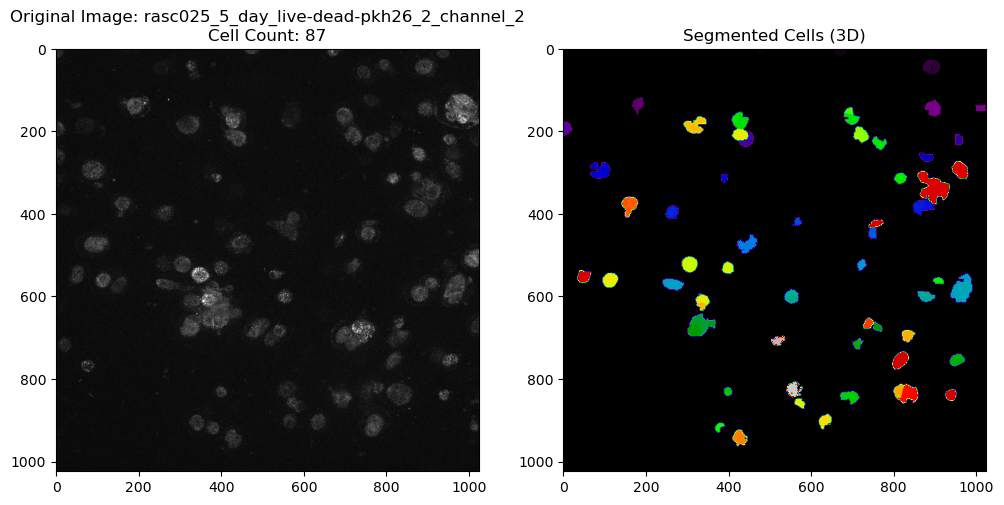

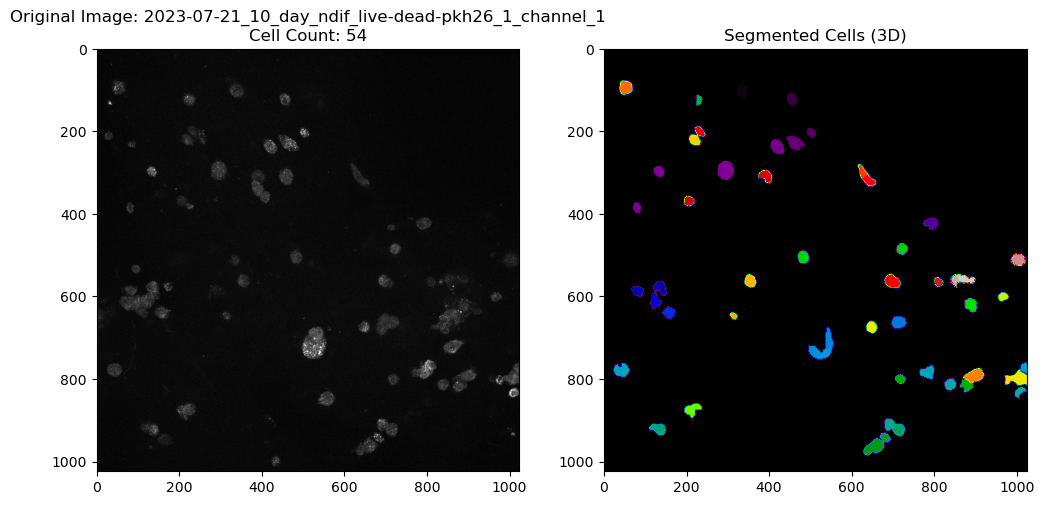

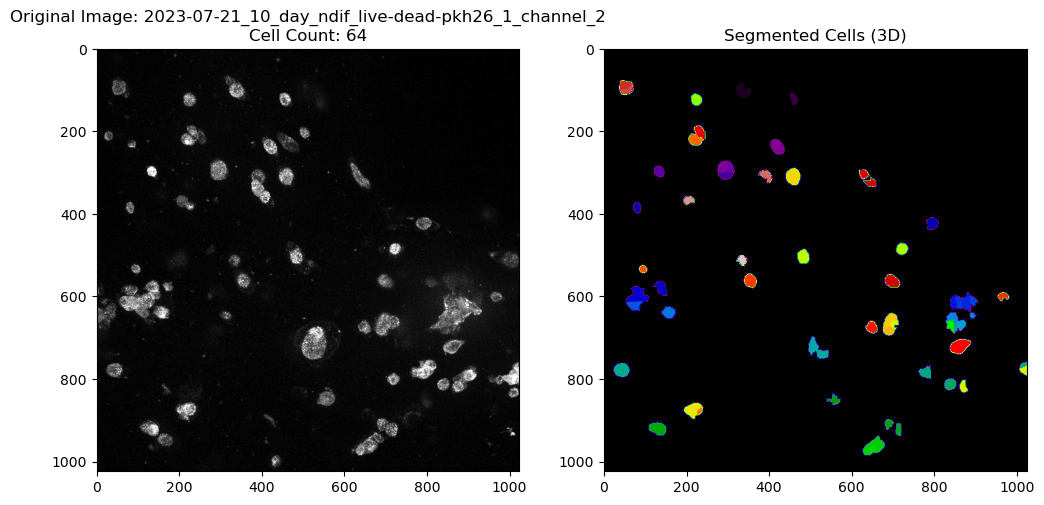

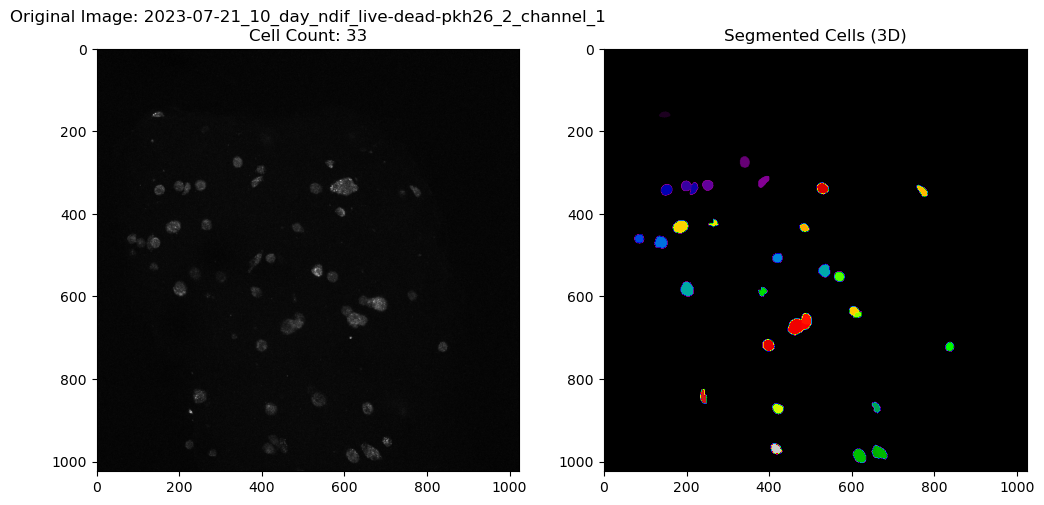

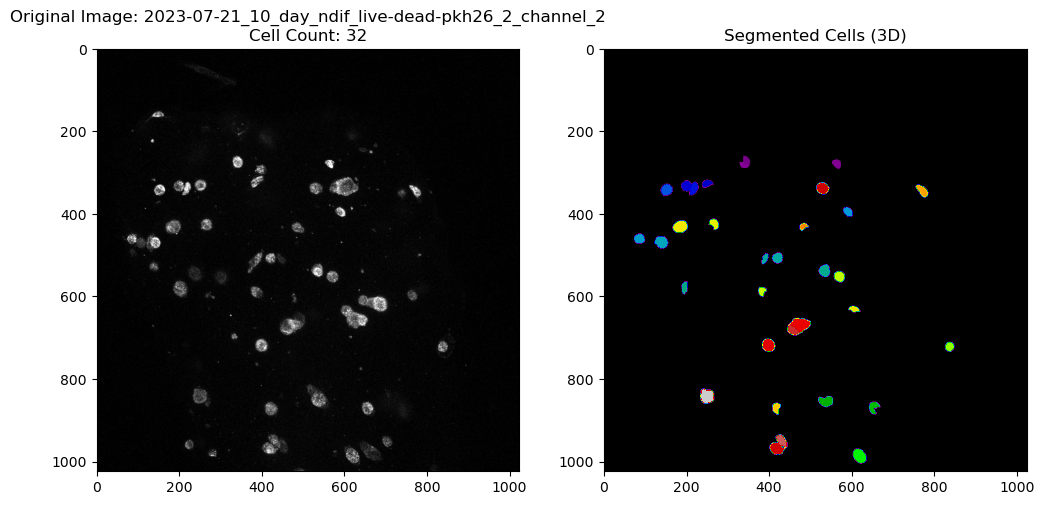

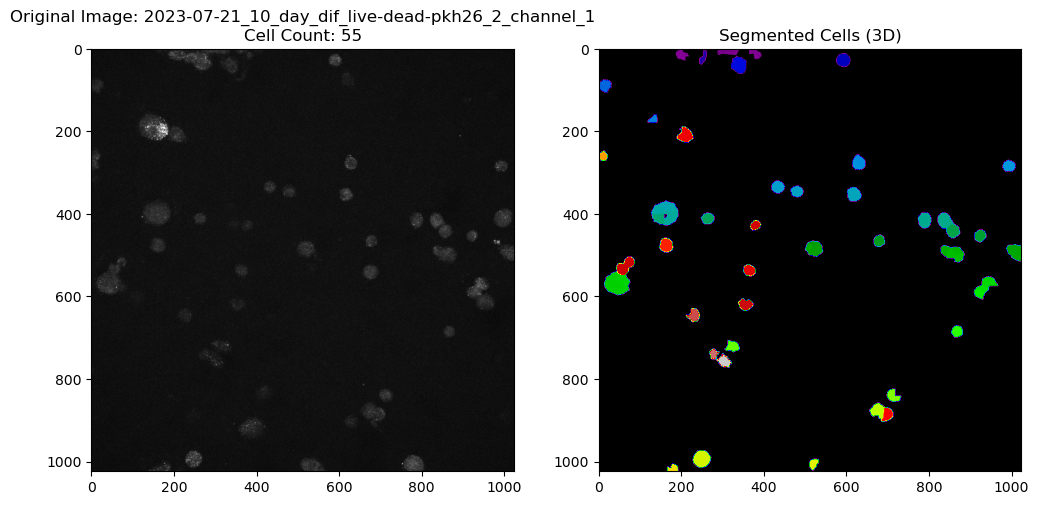

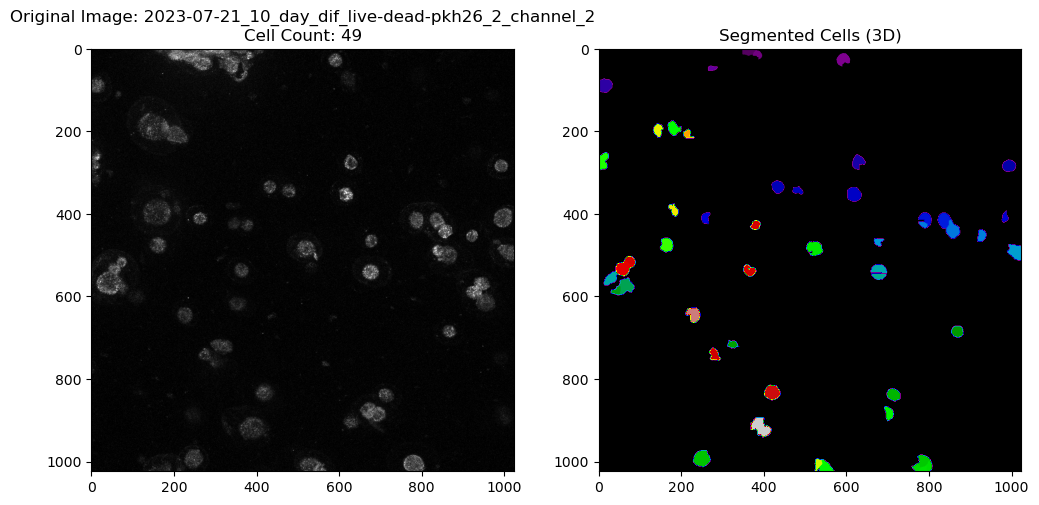

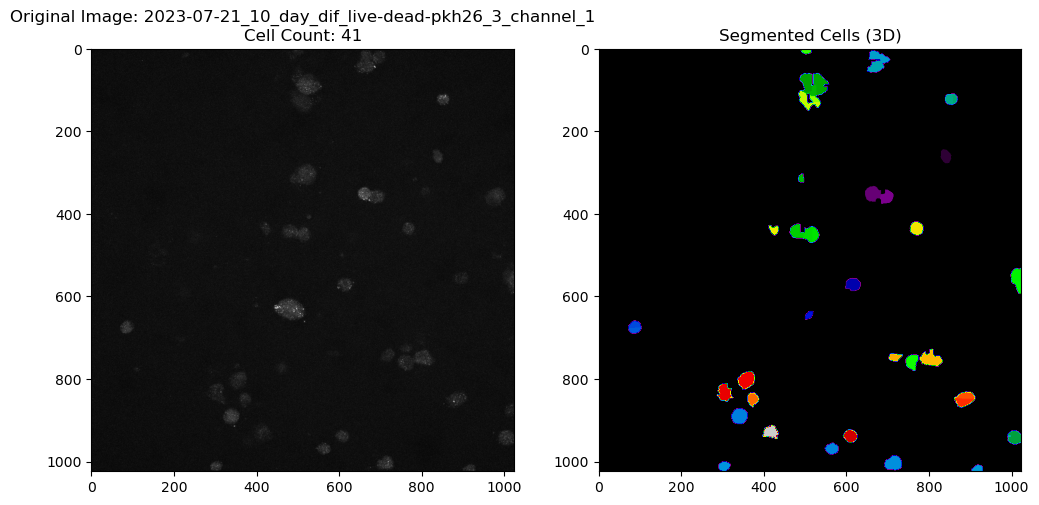

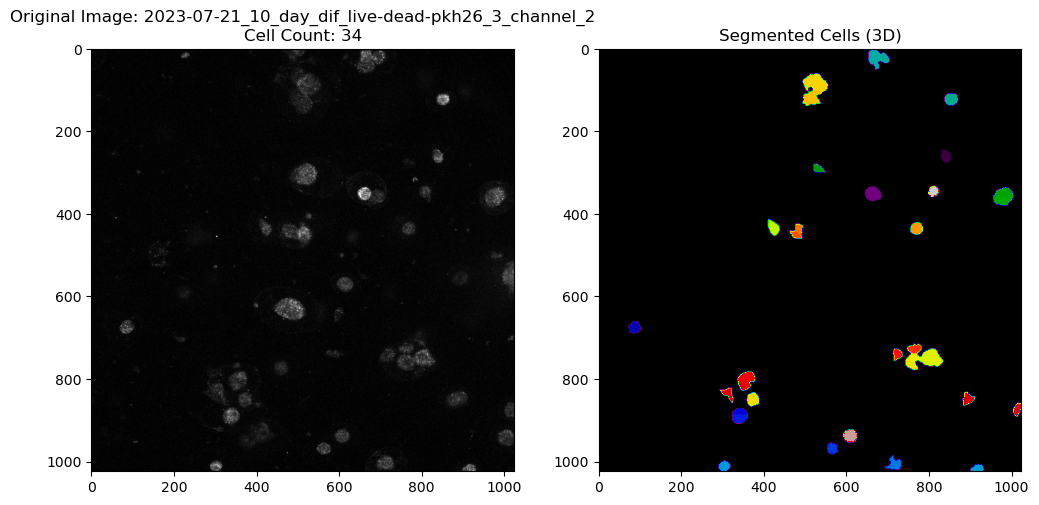

In [5]:
def count_cells(data):
    result_dict = {}
    for image_data in data:
        image_name = image_data["image_name"]
        channel_images = image_data["channel_images"]
        for channel_index, np_image in enumerate(channel_images[:2]):
            selected_slices = np_image[10:20]
            stacked_image = np.stack(selected_slices, axis=0)
            cell_count = cell_counter_3D(f"{image_name}_channel_{channel_index + 1}", stacked_image)
            result_dict[f"{image_name}_channel_{channel_index + 1}"] = cell_count
    return result_dict

result_dict = count_cells(day5_clean)
result_dict2 = count_cells(day10_clean)

In [6]:
def create_dataframe_from_dict(result_dict):
    channel_1_dict = {key: value for key, value in result_dict.items() if 'channel_1' in key}
    channel_2_dict = {key: value for key, value in result_dict.items() if 'channel_2' in key}

    channel_1_names = [key.rsplit('_channel_1', 1)[0] for key in channel_1_dict.keys()]
    channel_2_names = [key.rsplit('_channel_2', 1)[0] for key in channel_2_dict.keys()]

    all_image_names = sorted(set(channel_1_names) | set(channel_2_names))


    data = {
        'Channel 1': [channel_1_dict.get(name + '_channel_1', 0) for name in all_image_names],
        'Channel 2': [channel_2_dict.get(name + '_channel_2', 0) for name in all_image_names]
    }


    df = pd.DataFrame(data, index=all_image_names)
    return df


df1 = create_dataframe_from_dict(result_dict)
df2 = create_dataframe_from_dict(result_dict2)

df2

,Channel 1,Channel 2
2023-07-21_10_day_dif_live-dead-pkh26_2,55,49
2023-07-21_10_day_dif_live-dead-pkh26_3,41,34
2023-07-21_10_day_ndif_live-dead-pkh26_1,54,64
2023-07-21_10_day_ndif_live-dead-pkh26_2,33,32


In [7]:
#Live cells are in the second channel and the dead cells are in the first one
def calculate_live_dead_ratio(df):
    total_channel_1 = df['Channel 1'].sum()
    total_channel_2 = df['Channel 2'].sum()
    ratio = total_channel_1 / total_channel_2 if total_channel_2 != 0 else 0
    return ratio

ratio_day_5 = calculate_live_dead_ratio(df1)
ratio_day_10 = calculate_live_dead_ratio(df2)

live_dead_ratio_df = pd.DataFrame({'live/dead ratio': [ratio_day_5, ratio_day_10]}, index=['Day 5', 'Day 10'])

live_dead_ratio_df

,live/dead ratio
Day 5,0.800000
Day 10,1.022346


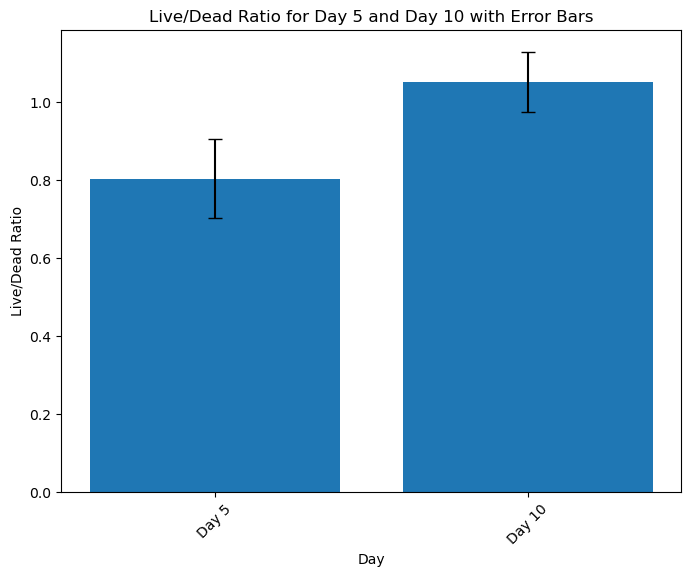

,live/dead ratio,std_error
Day 5,0.802382,0.101233
Day 10,1.050833,0.077694


In [8]:
def calculate_individual_ratios(df):
    ratios = df['Channel 1'] / df['Channel 2'].replace(0, np.nan) 
    return ratios.dropna() 


individual_ratios_day_5 = calculate_individual_ratios(df1)
individual_ratios_day_10 = calculate_individual_ratios(df2)


mean_ratio_day_5 = individual_ratios_day_5.mean()
std_error_day_5 = individual_ratios_day_5.std() / np.sqrt(len(individual_ratios_day_5))

mean_ratio_day_10 = individual_ratios_day_10.mean()
std_error_day_10 = individual_ratios_day_10.std() / np.sqrt(len(individual_ratios_day_10))


live_dead_ratio_df = pd.DataFrame({'live/dead ratio': [mean_ratio_day_5, mean_ratio_day_10],
                                   'std_error': [std_error_day_5, std_error_day_10]},
                                   index=['Day 5', 'Day 10'])


plt.figure(figsize=(8, 6))
plt.bar(live_dead_ratio_df.index, live_dead_ratio_df['live/dead ratio'], 
        yerr=live_dead_ratio_df['std_error'], capsize=5, color='tab:blue')
plt.xlabel('Day')
plt.ylabel('Live/Dead Ratio')
plt.title('Live/Dead Ratio for Day 5 and Day 10 with Error Bars')
plt.xticks(rotation=45)
plt.show()

live_dead_ratio_df